In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import xgboost as xgb

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import optuna
import os
from scipy import stats

import joblib

In [2]:
train = pd.read_csv("../data/train.csv")
predict = pd.read_csv("../data/test.csv")

# データの前処理

## 特徴量の作成

In [3]:
mapping = {
    'foggy': 1,
    'clear': 2,
    'rainy': 3
}

In [4]:
def create_features(df):
    # カーブと報告事故件数
    df['curavture_accidents'] = df['curvature'] * df['num_reported_accidents']
    #df['time_school_accidents'] = df['time_of_day'] +'_'+ df['num_reported_accidents'].astype(str)
    #df['weather_accidents'] = df['weather'] +'_'+ df['num_reported_accidents'].astype(str)
    #df['speed_accidents'] = df['speed_limit'] * df['num_reported_accidents']
    #df['cuavature_speed'] = df['curvature'] * df['speed_limit']

    #df['cuvature_weather'] = df['curvature'] * df['weather'].map(mapping)

    df['high_risk_codition'] = df['speed_limit'] >= 60 & (df['weather'] != 'clear')

    # --- BINARY列の作成 --- 数字の順序は意味のない，4つのbool型をまとめた特徴量の作成
    BINARY_COLS = ['road_signs_present', 'public_road', 'holiday', 'school_season']
    df['BINARY'] = 0
    for i in range(len(BINARY_COLS)):
        df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2 ** i)



    df['base_risk'] = (
        0.3 * df["curvature"] + 
        0.2 * (df["lighting"] == "night").astype(int) + 
        0.1 * (df["weather"] != "clear").astype(int) + 
        0.2 * (df["speed_limit"] >= 60).astype(int) + 
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
    )

    return df

train = create_features(train)
predict = create_features(predict)

### Object型のデータのラベル付け

In [5]:
"""
# Label Encoding

def label_encode(df, columns):
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

encode_columns = ['road_type','lighting','weather','time_of_day']
train = label_encode(train, encode_columns)
predict = label_encode(predict, encode_columns)
"""

"\n# Label Encoding\n\ndef label_encode(df, columns):\n    le = LabelEncoder()\n\n    for col in columns:\n        df[col] = le.fit_transform(df[col])\n    return df\n\nencode_columns = ['road_type','lighting','weather','time_of_day']\ntrain = label_encode(train, encode_columns)\npredict = label_encode(predict, encode_columns)\n"

In [6]:
# One-Hot Encoding
def one_hot_encode(df, columns):
    df = pd.get_dummies(df, columns=columns, drop_first=False)
    return df

encode_columns = ['road_type', 'lighting', 'weather', 'time_of_day']

# trainとpredictで同じダミー列に揃えるための処理
train = one_hot_encode(train, encode_columns)
predict = one_hot_encode(predict, encode_columns)

# 列がずれないように、trainにあってpredictにない列を補う
missing_cols = set(train.columns) - set(predict.columns)
for col in missing_cols:
    predict[col] = 0

# 列の順番をtrainと合わせる
predict = predict[train.columns]
predict = predict.drop(columns=['accident_risk'])

In [7]:
# bool型の変換

def bool_to_int(df):
    bool_columns = df.select_dtypes(include='bool').columns
    for col in bool_columns:
        df[col] = df[col].astype(int)
    return df

train = bool_to_int(train)
predict = bool_to_int(predict)

In [8]:
train.head()

,id,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,accident_risk,...,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,0,2,0.06,35,0,1,0,1,1,0.13,...,1,1,0,0,0,0,1,1,0,0
1,1,4,0.99,35,1,0,1,1,0,0.35,...,1,1,0,0,1,0,0,0,1,0
2,2,4,0.63,70,0,1,1,0,2,0.30,...,0,0,1,0,1,0,0,0,0,1
3,3,4,0.07,35,1,1,0,0,1,0.21,...,0,0,1,0,0,0,1,0,0,1
4,4,1,0.58,60,0,0,1,0,1,0.56,...,0,1,0,0,0,1,0,0,1,0


### スケーリング

In [9]:
# 残留誤差が大きいため，異常値に強いRobustScalerを使用
def robust_scale(df):
    scaler = RobustScaler()

    numeric_columns = ['curvature','curavture_accidents']

    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

train = robust_scale(train)
predict = robust_scale(predict)

### データ分割

In [10]:
def split_data(df,test_size=0.2,random_state=42):
    X = df.drop(columns=['id','accident_risk'])
    y = df['accident_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)

predict_X = predict.copy()
predict_X = predict_X.drop(columns=['id'])

# モデルの学習

In [11]:
from sklearn.ensemble import RandomForestRegressor

# ランダムフォレストモデルの構築
def build_random_forest_model(n_estimators=100, max_depth=5):
    """ランダムフォレスト回帰モデルを構築する関数"""
    model = RandomForestRegressor(
        # 決定木の数
        n_estimators=n_estimators,
        # 決定木の最大深さ
        max_depth=max_depth,
        # 乱数シード
        random_state=42,
        # 並列処理（CPUコアすべて使うなら -1）
        n_jobs=-1
    )
    return model

# モデルの構築
rf_model = build_random_forest_model()
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=42)

# モデルの評価

In [12]:
# テストデータの予測
rf_pred = rf_model.predict(X_test)

In [13]:
def evalute_metrics(y_true,y_pred):
    results = []

    def calulate_metrics(y_true,y_pred):
        mse = mean_squared_error(y_true,y_pred)
        mae = mean_absolute_error(y_true,y_pred)
        r2 = r2_score(y_true,y_pred)
        return {
            'MSE':mse,
            'MAE':mae,
            'R2':r2
        }

    results.append(calulate_metrics(y_true,y_pred))
    
    return pd.DataFrame(results)

# 評価指標の計算
results = evalute_metrics(y_test,rf_pred)
display(results)

,MSE,MAE,R2
0,0.003361,0.04488,0.878274


# 最適化学習

In [14]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def optimize_random_forest(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # 上限を500から300に変更
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 上限を20から15に変更
    # その他のパラメータはそのままでもOK
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    'max_features': trial.suggest_float('max_features', 0.1, 1.0),
    'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    'random_state': 42,
    'n_jobs': -1  # 並列計算を使って高速化を図る
}

    
    model = RandomForestRegressor(**params)
    model = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Create the study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(optimize_random_forest, n_trials=50)

# Display best results
print('Best trial:')
trial = study.best_trial
print(f"  MSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to creat-09
# poiuygfde and train the final model
optimized_rf = RandomForestRegressor(**trial.params, random_state=42, n_jobs=-1)
optimized_rf.fit(X_train, y_train)

[I 2025-10-19 12:09:30,499] A new study created in memory with name: no-name-65d97cb5-3af5-49d7-bc29-750b107feb13
[I 2025-10-19 12:09:45,405] Trial 0 finished with value: 0.0034887510214113545 and parameters: {'n_estimators': 271, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.9676737201801648, 'bootstrap': False}. Best is trial 0 with value: 0.0034887510214113545.
[I 2025-10-19 12:09:50,634] Trial 1 finished with value: 0.003664363266514493 and parameters: {'n_estimators': 257, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.12082275583622104, 'bootstrap': True}. Best is trial 0 with value: 0.0034887510214113545.
[I 2025-10-19 12:10:27,329] Trial 2 finished with value: 0.003164632181402199 and parameters: {'n_estimators': 281, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.9330177970523477, 'bootstrap': True}. Best is trial 2 with value: 0.003164632181402199.
[I 2025-10-19 12:10:46,7

Best trial:
  MSE: 0.0031623052241879905
  Params: 
    n_estimators: 223
    max_depth: 11
    min_samples_split: 10
    min_samples_leaf: 4
    max_features: 0.6152502708495085
    bootstrap: True


RandomForestRegressor(max_depth=11, max_features=0.6152502708495085,
                      min_samples_leaf=4, min_samples_split=10,
                      n_estimators=223, n_jobs=-1, random_state=42)

In [15]:
optimized_pred = optimized_rf.predict(X_test)
optimized_metrics = evalute_metrics(y_test,  optimized_pred) # 評価
display(optimized_metrics)

,MSE,MAE,R2
0,0.003162,0.043603,0.885474


In [16]:
def plot_residual_analysis(y_test, optimized_pred, figsize=(16, 12)):

    residuals = y_test - optimized_pred
    
    # 統計量の計算
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_test - np.mean(y_test))**2))
    
    # 2x2のサブプロット作成
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # ========================================
    # 1. 実際値 vs 予測値（左上）
    # ========================================
    ax1 = axes[0, 0]
    ax1.scatter(y_test, optimized_pred, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
    
    # 完全予測ライン（y=x）
    min_val = min(y_test.min(), optimized_pred.min())
    max_val = max(y_test.max(), optimized_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax1.set_xlabel('Actual Accident Risk', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicted Accident Risk', fontsize=12, fontweight='bold')
    ax1.set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 統計情報をテキストで表示
    textstr = f'RMSE: {rmse:.5f}\nMAE: {mae:.5f}\nR²: {r2:.5f}'
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # ========================================
    # 2. 残差プロット（右上）
    # ========================================
    ax2 = axes[0, 1]
    ax2.scatter(optimized_pred, residuals, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Residual')
    
    ax2.set_xlabel('Predicted Accident Risk', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 残差の範囲を表示
    std_residual = np.std(residuals)
    ax2.axhline(y=2*std_residual, color='orange', linestyle=':', alpha=0.7, label='±2σ')
    ax2.axhline(y=-2*std_residual, color='orange', linestyle=':', alpha=0.7)
    
    # ========================================
    # 3. 残差のヒストグラム（左下）
    # ========================================
    ax3 = axes[1, 0]
    ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    ax3.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero')
    ax3.axvline(x=np.mean(residuals), color='green', linestyle='-', lw=2, 
                label=f'Mean: {np.mean(residuals):.5f}')
    
    ax3.set_xlabel('Residuals', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax3.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========================================
    # 4. Q-Qプロット（右下）
    # ========================================
    ax4 = axes[1, 1]
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # 統計サマリーを出力
    # ========================================
    print("=" * 60)
    print("残差分析サマリー")
    print("=" * 60)
    print(f"サンプル数: {len(y_test)}")
    print(f"\n【評価指標】")
    print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
    print(f"MAE  (Mean Absolute Error):     {mae:.6f}")
    print(f"R²   (Coefficient of Determination): {r2:.6f}")
    print(f"\n【残差統計】")
    print(f"残差の平均:   {np.mean(residuals):.6f}")
    print(f"残差の標準偏差: {np.std(residuals):.6f}")
    print(f"残差の最小値: {np.min(residuals):.6f}")
    print(f"残差の最大値: {np.max(residuals):.6f}")
    print(f"\n【外れ値検出】")
    outliers = np.abs(residuals) > 2 * std_residual
    print(f"±2σを超える外れ値の数: {np.sum(outliers)} ({np.sum(outliers)/len(residuals)*100:.2f}%)")
    print("=" * 60)
    
    return residuals


def plot_residual_by_range(y_test, optimized_pred, n_bins=10, figsize=(14, 6)):
    """
    予測値の範囲別に残差を分析
    
    Parameters:
    -----------
    y_test : array-like
        実際の事故リスク値
    optimized_pred : array-like
        予測された事故リスク値
    n_bins : int
        ビンの数
    """
    residuals = y_test - optimized_pred
    
    # 予測値の範囲でビン分割
    bins = np.linspace(optimized_pred.min(), optimized_pred.max(), n_bins + 1)
    bin_indices = np.digitize(optimized_pred, bins)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 左: ビン別の平均残差
    ax1 = axes[0]
    mean_residuals = []
    bin_centers = []
    
    for i in range(1, n_bins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            mean_residuals.append(np.mean(residuals[mask]))
            bin_centers.append((bins[i-1] + bins[i]) / 2)
    
    ax1.bar(bin_centers, mean_residuals, width=(bins[1]-bins[0])*0.8, 
            edgecolor='black', alpha=0.7)
    ax1.axhline(y=0, color='r', linestyle='--', lw=2)
    ax1.set_xlabel('Predicted Accident Risk (Binned)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mean Residual', fontsize=12, fontweight='bold')
    ax1.set_title('Mean Residual by Prediction Range', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 右: ビン別の残差の分散
    ax2 = axes[1]
    std_residuals = []
    
    for i in range(1, n_bins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            std_residuals.append(np.std(residuals[mask]))
    
    ax2.bar(bin_centers, std_residuals, width=(bins[1]-bins[0])*0.8,
            edgecolor='black', alpha=0.7, color='orange')
    ax2.set_xlabel('Predicted Accident Risk (Binned)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Std Dev of Residuals', fontsize=12, fontweight='bold')
    ax2.set_title('Residual Variance by Prediction Range', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


def plot_error_distribution(y_test, optimized_pred, figsize=(14, 5)):
    """
    誤差の詳細な分布分析
    """
    residuals = y_test - optimized_pred
    abs_errors = np.abs(residuals)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # 1. 絶対誤差の累積分布
    ax1 = axes[0]
    sorted_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    ax1.plot(sorted_errors, cumulative, linewidth=2)
    ax1.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # パーセンタイルを表示
    percentiles = [50, 75, 90, 95]
    for p in percentiles:
        val = np.percentile(abs_errors, p)
        ax1.axvline(x=val, linestyle='--', alpha=0.5, 
                   label=f'{p}%ile: {val:.4f}')
    ax1.legend(fontsize=9)
    
    # 2. 誤差率のヒストグラム
    ax2 = axes[1]
    error_percent = (residuals / y_test) * 100
    error_percent = error_percent[~np.isnan(error_percent) & ~np.isinf(error_percent)]
    ax2.hist(error_percent, bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.axvline(x=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Error Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Relative Error Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. 誤差の箱ひげ図
    ax3 = axes[2]
    bp = ax3.boxplot([residuals], labels=['Residuals'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    ax3.axhline(y=0, color='r', linestyle='--', lw=2)
    ax3.set_ylabel('Residuals', fontsize=12, fontweight='bold')
    ax3.set_title('Residual Box Plot', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n誤差パーセンタイル:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"{p}%: {np.percentile(abs_errors, p):.6f}")


# ========================================
# 使用例
# ========================================
if __name__ == "__main__":
    print("=" * 60)
    print("残差プロット分析ツール")
    print("=" * 60)
    print("\n使い方:")
    print("1. 基本的な残差分析:")
    print("   residuals = plot_residual_analysis(y_test, optimized_pred)")
    print("\n2. 予測範囲別の分析:")
    print("   plot_residual_by_range(y_test, optimized_pred)")
    print("\n3. 誤差分布の詳細分析:")
    print("   plot_error_distribution(y_test, optimized_pred)")
    print("\n必要なデータ:")
    print("  - y_test: 実際の事故リスク値（正解データ）")
    print("  - optimized_pred: 予測された事故リスク値")
    print("=" * 60)

残差プロット分析ツール

使い方:
1. 基本的な残差分析:
   residuals = plot_residual_analysis(y_test, optimized_pred)

2. 予測範囲別の分析:
   plot_residual_by_range(y_test, optimized_pred)

3. 誤差分布の詳細分析:
   plot_error_distribution(y_test, optimized_pred)

必要なデータ:
  - y_test: 実際の事故リスク値（正解データ）
  - optimized_pred: 予測された事故リスク値


1. 総合残差分析


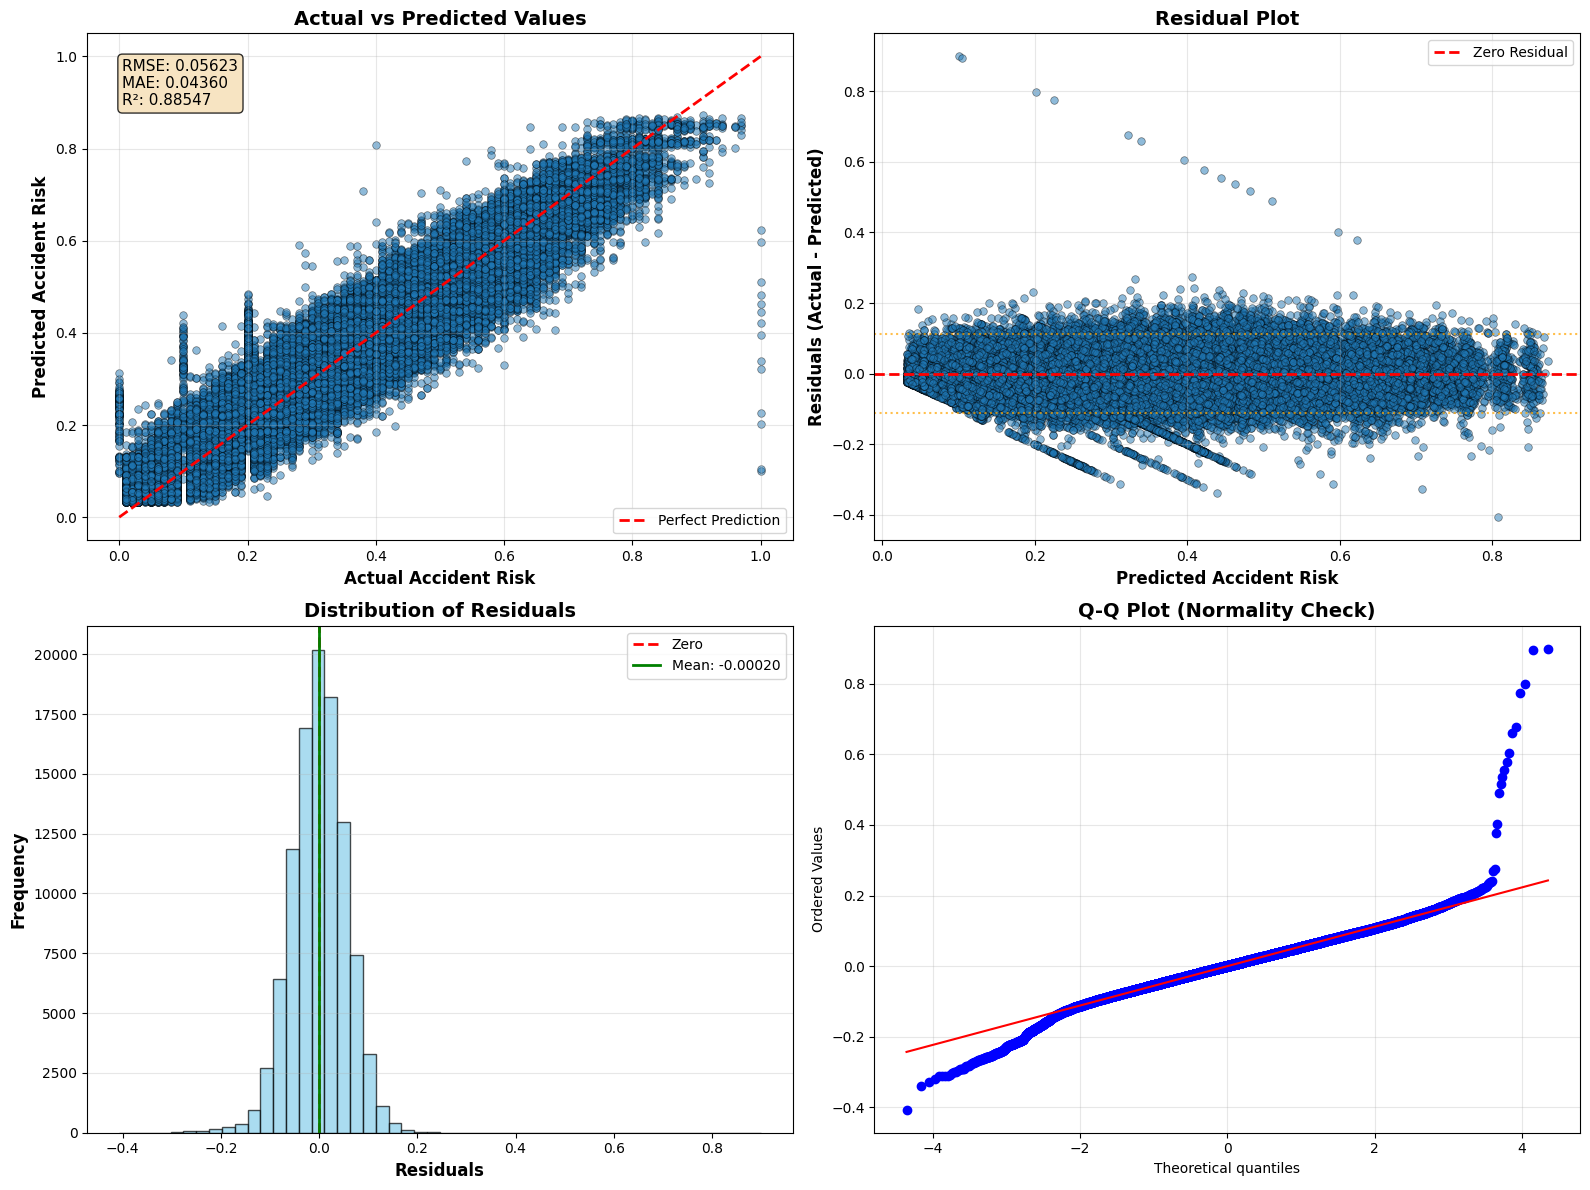

残差分析サマリー
サンプル数: 103551

【評価指標】
RMSE (Root Mean Squared Error): 0.056234
MAE  (Mean Absolute Error):     0.043603
R²   (Coefficient of Determination): 0.885474

【残差統計】
残差の平均:   -0.000198
残差の標準偏差: 0.056234
残差の最小値: -0.406877
残差の最大値: 0.899073

【外れ値検出】
±2σを超える外れ値の数: 4265 (4.12%)

2. 予測範囲別の残差分析


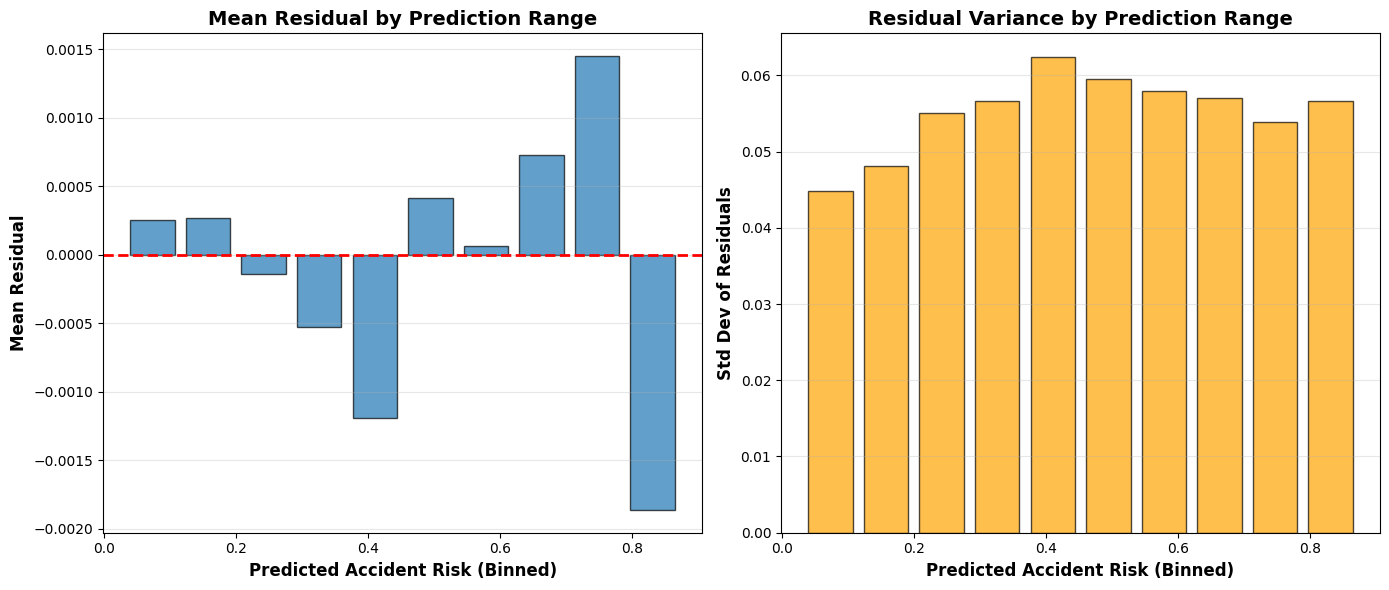


3. 誤差分布の詳細分析


/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_37052/4210867147.py:203: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([residuals], labels=['Residuals'], patch_artist=True)


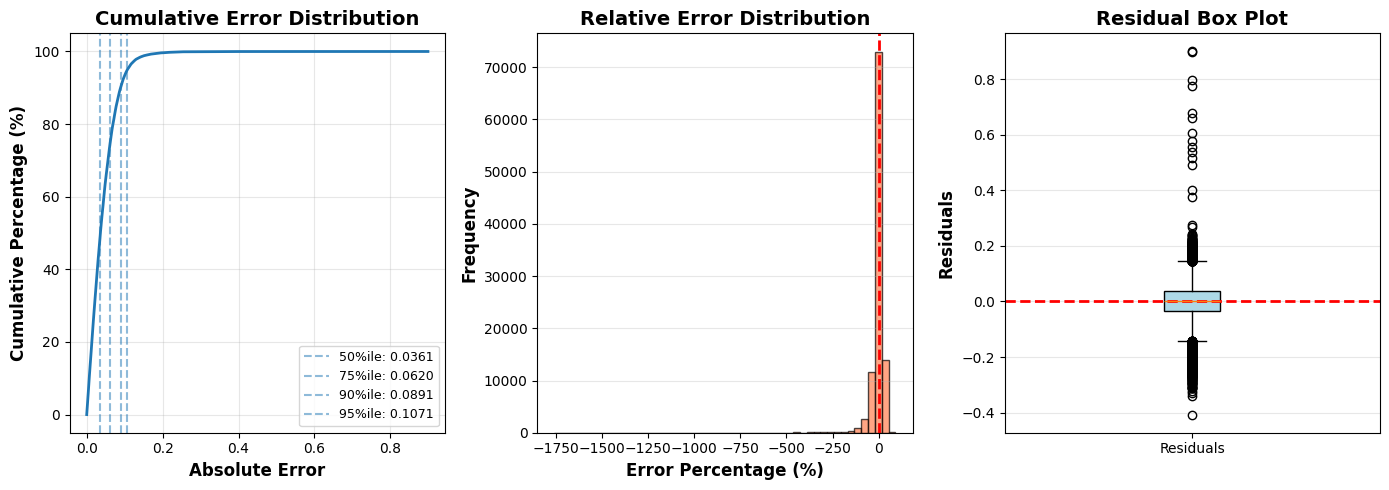


誤差パーセンタイル:
25%: 0.016936
50%: 0.036053
75%: 0.061986
90%: 0.089143
95%: 0.107127
99%: 0.157067


In [17]:
# 1. 総合分析（最も重要）
print("=" * 60)
print("1. 総合残差分析")
print("=" * 60)
residuals = plot_residual_analysis(y_test, optimized_pred)

# 2. 範囲別分析
print("\n" + "=" * 60)
print("2. 予測範囲別の残差分析")
print("=" * 60)
plot_residual_by_range(y_test, optimized_pred, n_bins=10)

# 3. 誤差分布分析
print("\n" + "=" * 60)
print("3. 誤差分布の詳細分析")
print("=" * 60)
plot_error_distribution(y_test, optimized_pred)

In [23]:
import joblib
import os

file_path = "model/rf_model/rf_model_3.pkl"

# フォルダがなければ作成
os.makedirs(os.path.dirname(file_path), exist_ok=True)

if os.path.exists(file_path):
    print(f"⚠️ ファイルが既にあります: {file_path}")
else:
    joblib.dump(optimized_rf, file_path)
    print(f"✅ モデルを保存しました: {file_path}")


✅ モデルを保存しました: model/rf_model/rf_model_3.pkl


## 提出準備

In [19]:
# テストデータ予測
predict_y = optimized_rf.predict(predict_X)
predict_df = pd.DataFrame(predict_y, columns=['accident_risk'])
submission = pd.concat([predict['id'], predict_df], axis=1)

display(submission.head())
print(submission.isnull().sum())

,id,accident_risk
0,517754,0.296775
1,517755,0.121526
2,517756,0.177522
3,517757,0.323609
4,517758,0.412084


id               0
accident_risk    0
dtype: int64


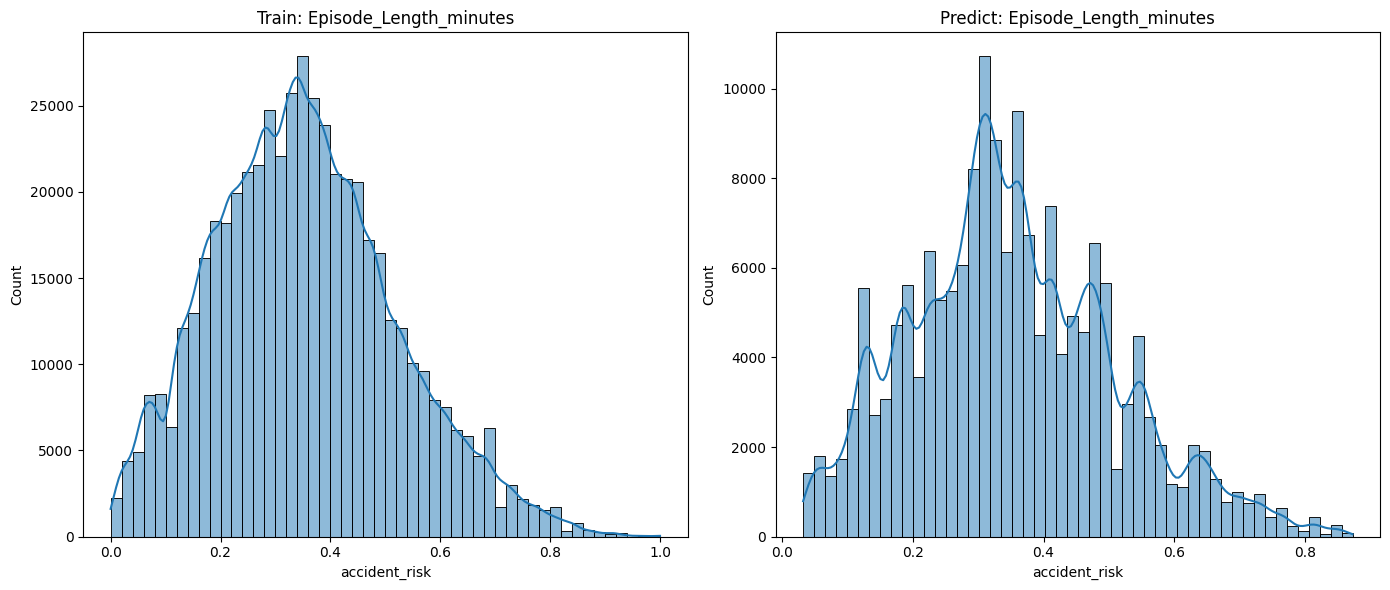

In [20]:
# サブプロットの準備（横に2つ）
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# train データのヒストグラム + KDE
sns.histplot(train['accident_risk'].dropna(), kde=True, bins=50, ax=axs[0])
axs[0].set_title('Train: Episode_Length_minutes')
#axs[0].set_xlabel('Episode_Length_minutes')

# predict データのヒストグラム + KDE
sns.histplot(submission['accident_risk'].dropna(), kde=True, bins=50, ax=axs[1])
axs[1].set_title('Predict: Episode_Length_minutes')
#axs[1].set_xlabel('Episode_Length_minutes')

# レイアウト調整して表示
plt.tight_layout()
plt.show()

In [22]:
file_path = '../submit/rf/random_model_3.csv'

if os.path.exists(file_path):
     print(f"ファイルが既にあります{file_path}.")
else:
    submission.to_csv(file_path, index=False)
    print(f"ファイルを保存しました: {file_path}")

ファイルを保存しました: ../submit/rf/random_model_3.csv
